# ANYTRACK TUTORIAL (ROBOT DOG)

This demo is a walkthrough starting from how to capture multiview videos to training AnyTrack to get labels and visualizing it.

>All the data required to follow along the demo can be downloaded from [Google Cloud](gs://aiml-shop-anytrack-data/robot_dog).

* Using Google Cloud CLI (see: https://cloud.google.com/sdk/docs/install-sdk) you can use the resource locator `gs://aiml-shop-anytrack-data/robot_dog` as follows `gsutil -m cp -r gs://aiml-shop-anytrack-data/robot_dog .` to copy this data to the current working directory.

## 1. Dataset

Below are the steps to create a dataset for Robot Dog. 

>``Note:`` The setup and instructions are assuming the usage of iphones to capture videos from multiple view. Adapt the respective sections according to the hardware used. 

### 1.1 Data Acquisition 

#### 1.1.1 Equipment

1. Three iOS devices under the same Apple ID account . 

1. Filmic Legacy aka Filmic Pro v6 to shoot videos. 

1. The smartphones mounted in tripod clamps and attached to tripods at a height of about 1.5 m, pointed at an area where the subject will perform the moves. 

1. A3 sheets placed in the field of view with a ChArUco board (see [tutorial](https://docs.opencv.org/3.4/df/d4a/tutorial_charuco_detection.html)). 


    >``Notes:`` 
    >* All the cameras have a rolling shutter, whereas a global shutter would be preferable. 
    
    >* The important thing is to get the highest quality recording with the least lossy compression and good illumination, this could be Android or any high-quality camera capable of recording at a high data rate. 

    >* We need the frame rate to be consistent and the cameras to be far enough apart from each other that parallax has an effect but close enough, so they are within 45 degrees when comparing the lens aperture axis of the nearby lenses. 

    >* The subject should occupy between 10 and 90% of the area of frames for most of the frames of the footage. 


#### 1.1.2 Software Settings 


* The demo footage was recorded with a high bit rate setting “Quality: Filmic Extreme” yet only 8bits per pixel in the RGB channels meant the dynamic range was clamped to 255 integer levels. 

* The white balance and ISO were not checked but will be recorded into the header of the original footage. All cameras were assigned a frame rate of 60Hz.  

* If later model cameras were used, we could use a [Gamut](https://en.wikipedia.org/wiki/Gamut) with a high dynamic range  such as Rec709, Rec2020, Dolby Vision etc, but as we are delivering to an 8bit per channel JPEG format this may be less important. [link](https://www.androidauthority.com/color-gamuts-guide-3035782/)

* The resolution was 1920 x 1080 as a progressive rolling shutter, so it fits the standard sRGB 1080p60 

* Having a consistent resolution is not a requirement, but an identical frame rate for temporal registration is important. The higher the quality and the fewest generations of loss will improve the overall result. 

#### 1.1.3 Start, Clap and Stop 

Trigger The cameras by tapping the iPhone screen sequentially then before the motion begun three loud claps took place to help synchronise the footage to within +/- one sixtieth of a second. The demo footage was around 900 frames from three cameras recording all at once. 

>``Note:`` The demo footage can be found at [Google Cloud](gs://aiml-shop-anytrack-data/robot_dog/raw_video )

* Using Google Cloud CLI (see: https://cloud.google.com/sdk/docs/install-sdk) you can use the resource locator `gs://aiml-shop-anytrack-data/robot_dog/raw_video` as follows `gsutil -m cp -r gs://aiml-shop-anytrack-data/robot_dog/raw_video .` to copy this data to the current working directory.

### 1.2 Synchronisation and Trimming 


#### 1.2.1 Egress from Camera and Conversion to Lossless RLE/Animation Codec 

1. Copy the videos to a local disk. 

1. Use FFMPEG to convert lossless run length encoded format as follows [link](https://superuser.com/questions/787166/transcoding-video-to-quicktime-animation-rle)

    ```bash
    ffmpeg -i input.mov -codec copy -c:v qtrle input_rle.mov 

    ffmpeg -h encoder=qtrle 
    ``` 

#### 1.2.2 Sync videos using waveform

Editing Software: DaVinci Resolve from Blackmagic Design on [Ubuntu 22.04](https://linux.how2shout.com/how-to-install-davinci-resolve-on-ubuntu-22-04-lts-jammy/ ) 

DaVinci Resolve versions without licensing cost only supports a few codecs, not including Apple ProRes, which is the output codec from Filmic Legacy, so they are converted to a lossless Animation RLE format in the step above. 

Alignment of the clips by the waveform preview is simple if you have experience in using DaVinci Resolve, but can also be done automatically. [link](https://dribbble.com/shots/16499894-How-to-Sync-Audio-in-DaVinci-Resolve)

Trimming clips is explained [here](https://www.blackmagicdesign.com/au/products/davinciresolve/cut#:~:text=remains%20the%20same.-,Trim,automatically%20ripple%20the%20timeline%20duration).


Once the three cameras are stacked on the timeline export is as follows:

![alt](graphics/7yWLeM.png)
![alt](graphics/Var36Y.png)



This will create folders, from here we can use Python to rename the sequences to files called “NNNN.jpg” in folders called “CAM_1”, “CAM_2” and “CAM_3”, ensure numbering starts from 1 not from 0. For disposable AWK scripts one liners see this [tutorial](https://askubuntu.com/questions/1038101/renaming-large-number-of-image-files-with-bash )

for example and AWK one liner such as 

`ls -1 *_*.jpg | awk -F "_" '{print "mv "$0" "$2}' | sh`

will convert `Clip_NNNN.jpg` to `NNNN.jpg` where `NNNN` is a four digit padded frame number

At this point your data should look like .

```
    -- input_RobotDog
            |-- CAM_1/
                |-- 0001.jpg
                |-- 0002.jpg
                |-- 0003.jpg
                ..
            |-- CAM_2/
                |-- 0001.jpg
                |-- 0002.jpg
                |-- 0003.jpg
                ..
            |-- CAM_3/
                |-- 0001.jpg
                |-- 0002.jpg
                |-- 0003.jpg
                ..
```
>``Note:`` Demo data at this stage can be downloaded from [Google Cloud](gs://aiml-shop-anytrack-data/robot_dog/input_RobotDog) 

* Using Google Cloud CLI (see: https://cloud.google.com/sdk/docs/install-sdk) you can use the resource locator `gs://aiml-shop-anytrack-data/robot_dog/input_RobotDog` as follows `gsutil -m cp gs://aiml-shop-anytrack-data/robot_dog/input_RobotDog .` to copy this data to the current working directory.



### 1.3 Creating dataset


Create a json file as shown below in ``configs/joints/RobotDog.json``.
```json
        { 
            "num_joints": 4, 
            "joint_connections": [ 
                [0, 1], 
                [1, 2], 
                [3, 4], 
                [4, 5] 
            ], 
            "joints_name": ["front_upper", "front_mid", "front_foot", "rear_upper","rear_mid","rear_foot"], 
            "range_scale": 1, 
            "R": [ 
                [1.0, 0.0, 0.0], 
                [0.0, 1.0, 0.0], 
                [0.0, 1.0, 0.0] 
            ] 
        } 
```



Now we need to pick images from this dataset to annotate. Run the below command to generate a folder called ``ann_images`` containing images to be annotated.



In [10]:
!python scripts/create_dataset.py --data /home/aaron/data/aiml_shop/input_RobotDog --name RobotDog --percent 2 

Total frames in the video are:  783
Need to annotate 16
Copying images for CAM_1
100%|███████████████████████████████████████| 783/783 [00:00<00:00, 4692.71it/s]
Total frames in the video are:  783
Need to annotate 16
Copying images for CAM_2
100%|███████████████████████████████████████| 783/783 [00:00<00:00, 3663.99it/s]
Total frames in the video are:  783
Need to annotate 16
Copying images for CAM_3
100%|███████████████████████████████████████| 783/783 [00:00<00:00, 4095.08it/s]
Dataset created at /home/aaron/code/aiml_shop/mbw/abc/data/RobotDog



A folder ``data/RobotDog`` will be created with subfolders ``images/CAM_1`` ``images/CAM_2`` ``images/CAM_3`` and Annotations ``ann_images/CAM_1`` ``ann_images/CAM_2`` ``ann_images/CAM_3`` 

Now annotate each view in folder ``data/RobotDog/ann_images`` seperately in a annotation tool ``Label Studio`` . The labels should be same as ``joints_name`` defined few steps above. 

* Using LabelStudio (see: https://labelstud.io/guide/) to create Keypoint detection annotations

* If this is not a familiar task, refer to this guide: https://blog.roboflow.com/how-to-use-label-studio/ but instead of creating box shaped annotations for object detection, use "Keypoint detections" in the "Labelling Setup" stage, the names of the labels should exactly match the ``joints_name``  in the `configs/joints`   JSON file. Note this tutorial expects ``COCO`` output, but we will use ``JSON-MIN``

* You will need to repeat the task of importing each camera view data as its own Label Studio "Project" and creating the keypoint detection in the labelling setup and creating the label names, the saving will come from the fact you are only labelling about 2% of the frames.

>Export annotated data in ``JSON-MIN`` format and then rename it to match view name, the default output is a time stamped name of the dataset with the `.json` extension, see image below for the pattern.


In [ ]:
!label-studio start

Copy the ``renamed`` json files to ``data/RobotDog/annot``
    ![alt text](graphics/json_rename.png "Title")

Now to make pickle files run 


In [12]:
!python scripts/create_pckl.py --data data --joints configs/joints/RobotDog.json --name RobotDog

Pickle files created at abc/data/RobotDog/annot



Run the below command to test if we have everything


In [1]:
!python common/preprocess.py --dataset RobotDog --percentage_if_gt 10 --host localhost --port 8080

Dataset without G.T. | Manually annoated with 2.04% annotations
Specifically, we have 16.0 total frames annotated per view
********************************************************************************************
We have enough annotations. Let us proceed with AnyTrack!
Alright, we have something


At this point your data folder will look like

```
    .
    └── data/
        └── RobotDog/
            ├── annot/
            │   ├── CAM_1.json
            │   ├── CAM_1.pkl
            │   ├── CAM_2.json
            │   ├── CAM_2.pkl
            │   ├── CAM_3.json
            │   └── CAM_3.pkl
            ├── ann_images/
            │   ├── CAM_1/
            │   │   ├── 001.jpg
            │   │   └── ..
            │   ├── CAM_2/
            │   │   ├── 001.jpg
            │   │   └── ..
            │   └── CAM_3/
            │       ├── 001.jpg
            │       └── ..
            └── images/
                ├── CAM_1/
                │   ├── 001.jpg
                │   └── ..
                ├── CAM_2/
                │   ├── 001.jpg
                │   └── ..
                └── CAM_3/
                    ├── 001.jpg
                    └── ..
```
&nbsp;
The data at this point of demo can be downloaded from [Google Cloud](gs://aiml-shop-anytrack-data/robot_dog/data)

* Using Google Cloud CLI (see: https://cloud.google.com/sdk/docs/install-sdk) you can use the resource locator `gs://aiml-shop-anytrack-data/robot_dog/data` as follows `gsutil -m cp -r gs://aiml-shop-anytrack-data/robot_dog/data .` to copy this data to the current working directory.

## 2. Training (Generate labels from AnyTrack)

>Before Training you need to make sure the ``scripts/train.sh`` script is pointing to the correct GPU number and the correct dataset. Change to dataset=”RobotDog” in this case. 
>With three cameras at 1080p you need to change the batch size so the project will not get an out of memory error, even with a 48Gb GPU. The batch size setting is found in “configs/detector.yaml” 

To start training



In [ ]:
!./scripts/train.sh

>``Note:``If training stops inbetween due to OOM, you should reduce the Batch size further. On the other hand, we can run the below cells before starting training again. Go through one of the pickle files to find upto which iteration it has completed. Run the eval step on that iteration. 

In [17]:
!CUDA_VISIBLE_DEVICES=0 nice -10 python modules/detector/eval.py --cfg configs/detector.yaml --dataset=RobotDog --scale_factor=200 --leverage_prior_object_knowledge='True' --pretrain_model_dataset=RobotDog --MBW_Iteration=4

Detector validates over 2.04% samples
--------------------------------------------------------
=> loading model from models/detector/RobotDog/model_best.pth
=> load 2349 samples
Test: [0/16]	Time 4.701 (4.701)	Loss 0.0000 (0.0000)	Accuracy 1.000 (1.000)
Test: [1/16]	Time 0.300 (1.770)	Loss 0.0000 (0.0000)	Accuracy 1.000 (1.000)
Test: [2/16]	Time 0.301 (1.182)	Loss 0.0000 (0.0000)	Accuracy 1.000 (1.000)
Test: [3/16]	Time 0.301 (0.930)	Loss 0.0000 (0.0000)	Accuracy 0.996 (0.999)
Test: [4/16]	Time 0.302 (0.789)	Loss 0.0000 (0.0000)	Accuracy 0.996 (0.998)
Test: [5/16]	Time 0.302 (0.700)	Loss 0.0002 (0.0001)	Accuracy 0.956 (0.991)
Test: [6/16]	Time 0.303 (0.638)	Loss 0.0002 (0.0001)	Accuracy 0.962 (0.987)
Test: [7/16]	Time 0.301 (0.592)	Loss 0.0002 (0.0001)	Accuracy 0.951 (0.982)
Test: [8/16]	Time 0.302 (0.557)	Loss 0.0000 (0.0001)	Accuracy 1.000 (0.984)
Test: [9/16]	Time 0.301 (0.529)	Loss 0.0000 (0.0001)	Accuracy 0.998 (0.986)
Test: [10/16]	Time 0.302 (0.507)	Loss 0.0000 (0.0001)	Accuracy

## 3. Visualize

In [27]:
import numpy as np
import torch
import argparse
import json
import sys
from pathlib import Path
import _pickle as cPickle
import numpy as np
import torch.nn as nn
from natsort import natsorted
from torch import optim
from PIL import Image
from tqdm import tqdm
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import scipy.io as sio
from matplotlib.patches import Rectangle
import cv2
import matplotlib.image as img
import matplotlib.pyplot as plt
sys.path.append("modules/helpers")
sys.path.append("configs")
sys.path.append("common")

import robust_loss_pytorch.general
from configs.mv_nrsfm_configs import get_dictionary, get_seed
from modules.mvnrsfm.neural_prior_modules import (
    BlockSparseCodingLayer,
    CameraEstimator,
    OnPEstimator,
    SparseCodeExtractionLayer,
    VecSparseCodingLayer,
)
from util_cameras import normalize_3d_structure, procrustes_align
from util_common import get_device, make_dir, parse_boolean, extract_bone_connections, get_colors, load_datasets
from util_errors import computeMPJPE, error_ratio
from visualize import gen_predictions_with_confidence, gen_BBox_demo, get_figure3d


##### Choose between:
-  `visualize_only` or 
- `evaluate_visualize` (Coming Soon: Run inference code on your/provided data and then visualize)

In [28]:
type = 'visualize_only'
dataset = 'RobotDog'

##### Load the dataset.

In [29]:
""" Loading the dataset """
class ARGS:
  def __init__(self, dataset):
    self.dataset = dataset
    self.field_of_validation = "Predictions"
    self.MBW_Iteration = 6
    self.validate_manual_labels = False
    self.img_type=".jpg"

args = ARGS(dataset)
loaded_data, misc_data = load_datasets(args)

print("--- DATASET STATISTICS --- ")
print("Dataset loaded: {}".format(args.dataset))
print("Total views: {}".format(misc_data['total_views']))
print("Total frames: {}".format(misc_data['total_frames']))
print("# of joints: {}".format(misc_data['num_joints']))
print("Groundtruth available: ", misc_data['GT_Flag'])

--- DATASET STATISTICS --- 
Dataset loaded: RobotDog
Total views: 3
Total frames: 783
# of joints: 6
Groundtruth available:  False


##### Ask for frame numbers / views to visualize.

In [30]:
frame_to_visualize = 252           # Frame number to visualize
multi_views_visualize = True     # All views (side-by-side) visualization or single view visualization
view_to_visualize = 0            # Only input view if you want separate visualizations for the view

##### 2D Joints and Bounding Boxes visualization

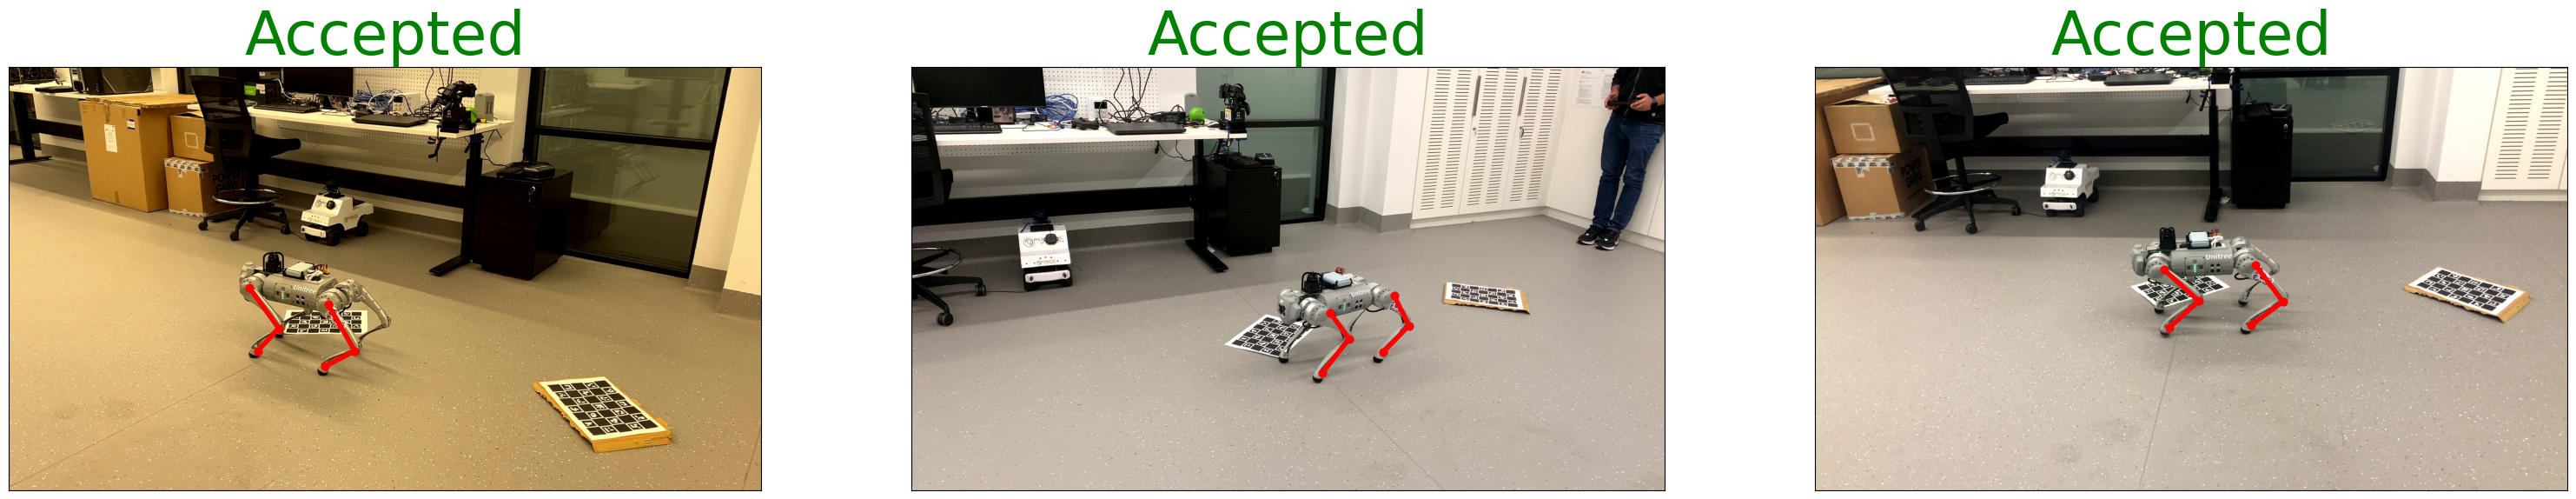

In [31]:
""" 2D Joints """
images = []
if multi_views_visualize:    
    for cam_idx in range(misc_data['total_views']):
        images.append(img.imread(misc_data['image_paths'][cam_idx][frame_to_visualize]))
else:
    images.append(img.imread(misc_data['image_paths'][view_to_visualize][frame_to_visualize]))

figure = gen_predictions_with_confidence(
    images,
    loaded_data['W_Pred'][:, frame_to_visualize, :, :],
    loaded_data['confidence'][:, frame_to_visualize],
    misc_data['joint_connections']
)

plt.show()
plt.cla()
plt.clf()
plt.close()



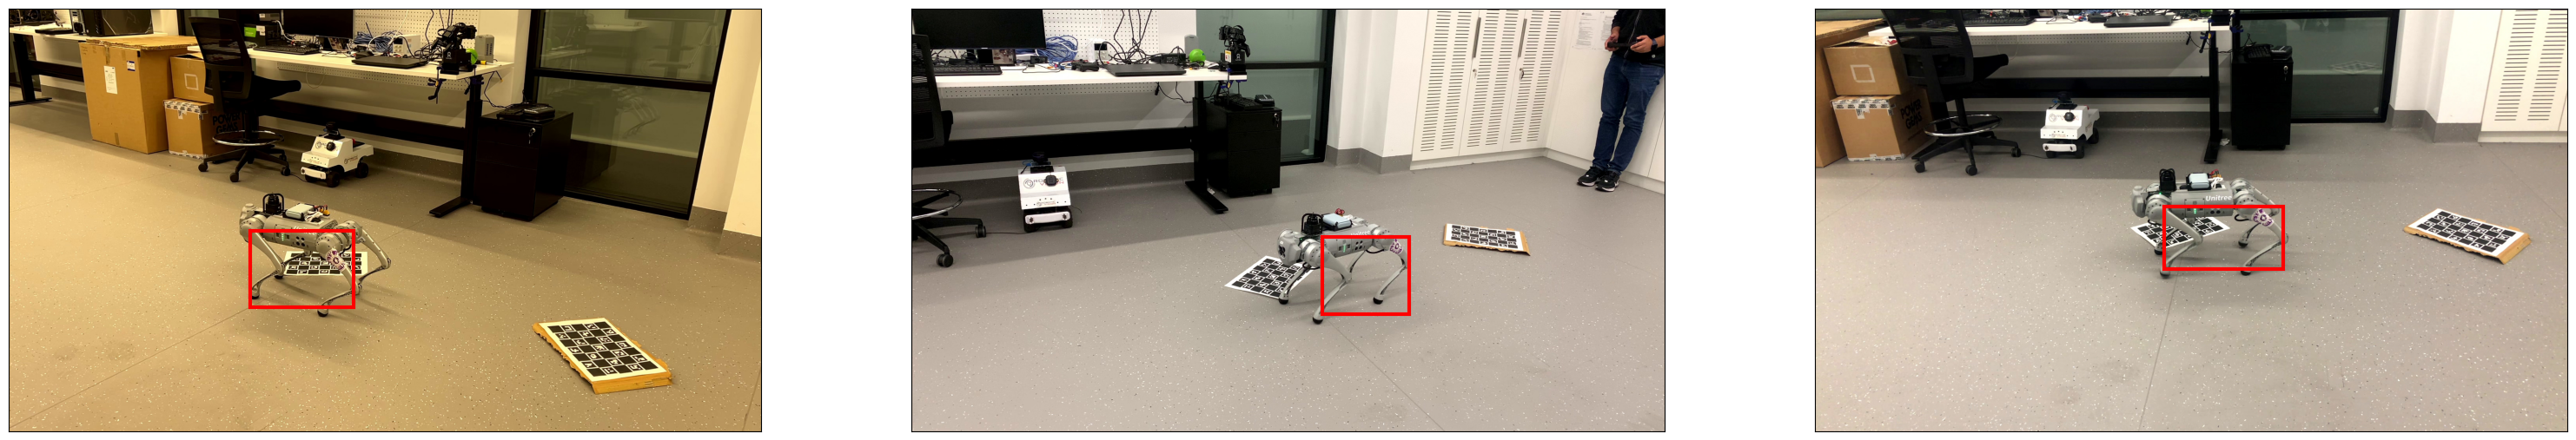

In [32]:
""" Bounding boxes """
figure = gen_BBox_demo(
    images,
    loaded_data['BBox'][:, frame_to_visualize, :],
    misc_data['joint_connections']
)
plt.show()
plt.cla()
plt.clf()
plt.close()

In [33]:
""" 3D structure """
fig = get_figure3d(
    misc_data['joint_connections'],
    -1.7678,
    0.0,
    -loaded_data['S_Pred'][0,frame_to_visualize, :, :] @ misc_data['rigid_rotation'],
    range_scale=1.3,
)
# -1.7678 and 0 arguments corresponds to random camera placement in 3D space.
py.iplot(fig)
plt.cla()
plt.clf()
plt.close()


To create a video of the labels run the below command

In [51]:
!python common/draw_kepoints.py --dataset RobotDog

--- DATASET STATISTICS --- 
Dataset loaded: RobotDog
Total views: 3
Total frames: 783
# of joints: 6
Groundtruth available:  False
Creating frames
100%|█████████████████████████████████████████| 783/783 [00:28<00:00, 27.15it/s]
creating video
100%|█████████████████████████████████████████| 783/783 [00:13<00:00, 56.03it/s]
Video saved at output.mp4
